In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPUs available")
    print('We will user the GPU:', torch.cuda.get_device_name(0))
else:
    print("사용 가능 지피유 없음 CPU로 전환")
    device = torch.device("cpu")

There are 1 GPUs available
We will user the GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [10]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils.git

Cloning into 'Tutorial-Book-Utils'...


In [14]:
%pip install gdown

  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.7-py3-none-any.whl.metadata (4.6 kB)
  Using cached PySocks-1.7.1-py3-none-any.whl.metadata (13 kB)
Using cached gdown-5.2.0-py3-none-any.whl (18 kB)
Using cached beautifulsoup4-4.13.4-py3-none-any.whl (187 kB)
Using cached soupsieve-2.7-py3-none-any.whl (36 kB)
Using cached PySocks-1.7.1-py3-none-any.whl (16 kB)

   ------------------------------ --------- 3/4 [gdown]
   ---------------------------------------- 4/4 [gdown]



In [15]:
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection

Face Mask Detection.zip download complete!


Downloading...
From (original): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7
From (redirected): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7&confirm=t&uuid=ff348f53-da90-44fe-9e24-8d109b39b505
To: c:\Users\main\Desktop\vision_project\ch05\Face Mask Detection.zip

  0%|          | 0.00/417M [00:00<?, ?B/s]
  0%|          | 524k/417M [00:00<04:03, 1.71MB/s]
  0%|          | 1.05M/417M [00:00<02:30, 2.77MB/s]
  1%|          | 2.62M/417M [00:00<01:06, 6.21MB/s]
  1%|          | 4.19M/417M [00:00<00:47, 8.71MB/s]
  3%|▎         | 12.1M/417M [00:00<00:14, 28.6MB/s]
  4%|▍         | 15.7M/417M [00:00<00:14, 28.1MB/s]
  5%|▍         | 19.4M/417M [00:01<00:16, 23.8MB/s]
  6%|▋         | 26.2M/417M [00:01<00:11, 33.7MB/s]
  7%|▋         | 30.4M/417M [00:01<00:15, 25.6MB/s]
  9%|▉         | 37.2M/417M [00:01<00:11, 33.9MB/s]
 10%|█         | 41.9M/417M [00:01<00:13, 27.0MB/s]
 11%|█         | 45.6M/417M [00:02<00:15, 24.3MB/s]
 12%|█▏        | 50.3M/417M [0

In [20]:
import zipfile
import os

# 압축파일 경로
zip_path = "Face_Mask_Detection.zip"  # 같은 폴더에 있다면 이대로 OK

# 압축을 풀 위치
extract_to = "./"

# 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("압축 해제 완료!")


압축 해제 완료!


In [21]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

853
853
683
683
170
170


In [23]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
from tqdm import tqdm

In [7]:
def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

adjust_label = 1

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1 + adjust_label
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2 + adjust_label
    return 0 + adjust_label

def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

def plot_image_from_output(img, annotation):
    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx].cpu()

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        elif annotation['labels'][idx] == 2 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        else :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')
        ax.add_patch(rect)

    plt.show()

In [8]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [10]:
data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

In [21]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [24]:
model = get_model_instance_segmentation(10)

device = torch.device('cuda')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [25]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')
    torch.save(model.state_dict(),f'model_{num_epochs}.pt')

----------------------train start--------------------------
epoch : 1, Loss : 79.65310668945312, time : 777.8692433834076
epoch : 2, Loss : 50.24831771850586, time : 775.4109671115875
epoch : 3, Loss : 43.55348205566406, time : 772.8744494915009
epoch : 4, Loss : 37.612823486328125, time : 758.949648141861
epoch : 5, Loss : 33.35744094848633, time : 764.9878420829773
epoch : 6, Loss : 31.549739837646484, time : 763.5660021305084
epoch : 7, Loss : 31.06505584716797, time : 765.4958870410919
epoch : 8, Loss : 28.076759338378906, time : 758.8278698921204
epoch : 9, Loss : 27.879384994506836, time : 780.9472947120667
epoch : 10, Loss : 25.87224006652832, time : 781.3565018177032


In [26]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [27]:
with torch.no_grad():
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[214.9099,  60.5817, 248.2614,  98.3027],
        [117.7553,   3.0105, 131.5378,  18.5279]], device='cuda:0'), 'labels': tensor([2, 2], device='cuda:0'), 'scores': tensor([0.9677, 0.8526], device='cuda:0')}, {'boxes': tensor([[218.4247,  99.9224, 257.4499, 138.8827],
        [132.6651, 110.4135, 176.5439, 153.6197],
        [  2.3713, 104.8016,  20.5132, 126.8092],
        [ 42.9844, 110.8191,  65.9045, 139.7843],
        [304.6628, 132.0225, 330.0938, 157.9520],
        [166.5001,  91.7447, 178.5133, 108.4480],
        [ 29.7031,  89.8190,  44.0236, 104.6045],
        [ 84.0712,  85.2003,  93.6463,  95.9941],
        [ 83.6571,  85.6518,  93.6061,  97.1151],
        [ 30.0992,  89.3111,  43.8824, 104.4512]], device='cuda:0'), 'labels': tensor([2, 2, 2, 1, 1, 1, 2, 1, 2, 1], device='cuda:0'), 'scores': tensor([0.9942, 0.9879, 0.9204, 0.9167, 0.8737, 0.7721, 0.5644, 0.5534, 0.5215,
        0.5012], device='cuda:0')}]


Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


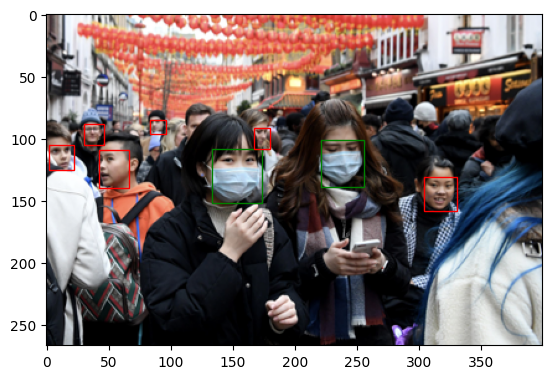

Prediction :  tensor([2, 2, 2, 1, 1, 1, 2, 1, 2, 1], device='cuda:0')


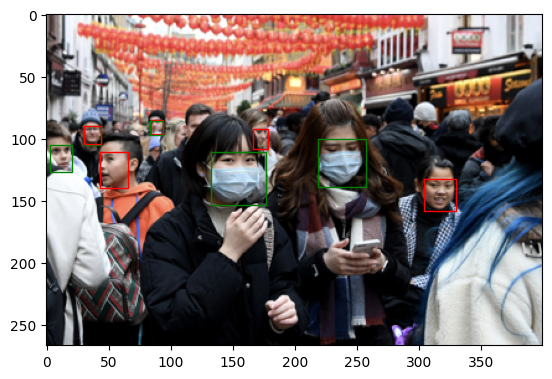

In [28]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])

In [29]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 85/85 [00:14<00:00,  5.80it/s]


In [30]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

c:\Users\main\Desktop\vision_project\ch05\Tutorial-Book-Utils


In [31]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.572550016566921
AP : tensor([0.5809, 0.9829, 0.1538], dtype=torch.float64)
